# DATA

In [1]:
# import packages
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.api import qqplot
from scipy.stats import anderson, normaltest, jarque_bera, shapiro
from fredapi import Fred

In [51]:
fred_api_key = "29b81578246f3b1d8661dfdb956124ba"
nasdaq_api_key = "7k6YjHjagWQK4UUNUnsZ"

## Cleaning and visualization functions

### Nan Values and datatype conversion

In [90]:
def get_all_nans(df: pd.DataFrame):
    """Displays all rows with NaN values for the given column"""
    print("All NaNs:")
    display(df.info())
    for col in df.columns:
        print("Column "+ col)
        display(get_nans_in_column(df, col))
        print()
    
def get_nans_in_column(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """Returns all NaN values for the given column"""
    mask = df[column].isna()
    return df.loc[mask]

def remove_nan_rows(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """Removes all rows where the given column has NaN values"""
    new_df = df.dropna(axis=0, subset=column)
    return new_df

def convert_columns_to_type(df: pd.DataFrame, mapping: dict[str: str]):
    """Converts given columns to specified datatype"""
    for key, val in mapping.items():
        df[key] = df[key].astype(val)

### Statistics and stationarity

In [451]:
def check_stationarity(df: pd.DataFrame):
    """Checks stationarity for all numeric columns (or the specified cols) in the dataframe using the adjusted Dicky-Fuller test"""
    # Select all numeric columns and checks the stationarity
    for col in df.select_dtypes(include=np.number):
        print("Column " + col)
        print("_"*10)
        result = adfuller(df[col].values)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
        print(f"{col} has a unit root(s) at the {result[1]:.2%} level")
        print()
        print()
        

def normality_check_graphical(df: pd.DataFrame, columns=[], figsize=(20, 20)):
    """Visualizes a QQ plot and histogram/kde plot for each numeric column/specified column to check for normality """
    # Plots qq plot, distribution plot and performs number of tests to check if normal
    columns = df.select_dtypes(include=np.number).columns if not columns else columns
    #fig, axs = plt.subplots(len(columns), 2, constrained_layout=True, figsize=figsize)
    fig = plt.figure(figsize=figsize, layout="constrained")
    subfigs = fig.subfigures(len(columns))
    for col, subfig in zip(columns, subfigs):
        subfig.suptitle(col, fontsize=16)
        ax = subfig.subplots(1, 2)
        sns.histplot(data=df[col], kde=True, ax=ax[0])
        qqplot(df[col], line="s", ax=ax[1])
        
def normality_check_statistical(df: pd.DataFrame, columns=[], alpha=0.01):
    """Performs four statistical tests for normality on the numeric/specified columns"""
    columns = df.select_dtypes(include=np.number).columns if not columns else columns
    for col in columns:
        print("Column: " + col)
        print()
        maps = {"Shapiro-Wiik test":shapiro, "D'Agostino K^2 test":normaltest, "Jarque-Bera test":jarque_bera}
        for key, val in maps.items():
            print(key)
            stat, p = shapiro(df[col])
            print(f"\tStatistics={stat:.3f}\tp={p:.3f}")
            if p > alpha:
                print(f'\tSample looks Gaussian (fail to reject H0 at {alpha:.1%} level)')
            else:
                print(f'\tSample does not look Gaussian (reject H0 at {alpha:.1%} level)')
            print()
        print("Anderson-Darling test")
        result = anderson(df[col])
        print('\tStatistic: %.3f' % result.statistic)
        for i in reversed(range(len(result.critical_values))):
            sl, cv = result.significance_level[i], result.critical_values[i]
            if result.statistic < result.critical_values[i]:
                print(f'\tCritical value {cv:.3f}, data looks normal (fail to reject H0 at {sl/100:.1%})')
            else:
                print(f'\tCritical value {cv:.3f}, data does not look normal (reject H0 at {sl/100:.1%})')
                break
        print("-"*20)

def quick_lineplot(df:pd.DataFrame, columns=None):
    """Visualizes the series given by numeric"""
    if type(df.index) != pd.core.indexes.datetimes.DatetimeIndex:
        print("The index has not been converted to a datetime index")
        return
    columns = df.select_dtypes(include=np.number).columns if not columns else columns
    with sns.plotting_context(context="paper"), sns.axes_style("darkgrid"):
        sns.lineplot(df[columns], palette="pastel")
        
def quick_distr_and_scatter_plot(df:pd.DataFrame, columns=None):
    """Plots a triangular plot of each column, where the diagonal is a KDE plot and the others are scatterplots"""
    columns = df.select_dtypes(include=np.number).columns if not columns else columns
    with sns.plotting_context(context="paper"), sns.axes_style("darkgrid"):
        sns.pairplot(fama_french, diag_kind="kde", corner=True)

## Get ticker names from sheets

In [85]:
data_names = pd.read_csv("data/Data master.csv", skiprows=2, )
data_names.columns = data_names.columns.str.strip()
data_names.columns

Index(['Paper source (DOI)', 'Type', 'Data source', 'Frequency', 'Name',
       'Ticker', 'Unnamed: 6', 'Unnamed: 7'],
      dtype='object')

# FRED

Helper function for displaying series info 

In [419]:
def get_fred_series_info(names:list[str]):
    with pd.option_context("display.max_colwidth", 200):
        for t in names:
            display(fred.get_series_info(t).to_frame())

## VIX

In [3]:
fred = Fred(api_key=fred_api_key)

In [ ]:
fred_names = data_names.loc[data_names["Data source"] == "FRED"]

Load VIX to get relevant start date

In [60]:
vix = fred.get_series('VIXCLS').to_frame(name="VIX")

In [496]:
start_date = vix.index[0]
end_date = vix.loc["2022"].index[-1]

The start date will be altered according to availablility of exogenous data

## Daily Fred

### Get ticker names for FRED data

In [87]:
daily_fred_names = fred_names.loc[fred_names.Frequency == "D"].Ticker
daily_fred_names

14            T10Y3M
15            BAA10Y
16             DGS10
18        DCOILWTICO
19          DTWEXBGS
30        USEPUINDXD
31        WLEMUINDXD
32      BAMLC0A4CBBB
33      BAMLC0A1CAAA
34    BAMLC0A4CBBBEY
35    BAMLC0A1CAAAEY
36        BAMLC0A0CM
37      BAMLC0A0CMEY
38             DFII5
39            DFII10
40             T5YIE
41            T10YIE
42              EFFR
43            OVXCLS
47             SP500
Name: Ticker, dtype: object

### Load daily data

In [497]:
daily_fred = fred.get_series(daily_fred_names.iloc[0], observation_start=start_date).to_frame(name=daily_fred_names.iloc[0])
for ticker in daily_fred_names.values[1:]:
    print(ticker)
    other = fred.get_series(ticker, observation_start=start_date).to_frame(name=ticker)
    daily_fred = daily_fred.join(other)

BAA10Y
DGS10
DCOILWTICO
DTWEXBGS
USEPUINDXD
WLEMUINDXD
BAMLC0A4CBBB
BAMLC0A1CAAA
BAMLC0A4CBBBEY
BAMLC0A1CAAAEY
BAMLC0A0CM
BAMLC0A0CMEY
DFII5
DFII10
T5YIE
T10YIE
EFFR
OVXCLS
SP500


### Handle NaNs

In [302]:
def nan_overview(df):
    """
    Prints the number of NaNs in the dataframe, where the first NaN value occurs, 
    number of NaNs after the first non-NaN value, and finally the number of negative values.
    """
    for col in df.columns:
        mask = df[col].isna()
        print(col)
        print("Last 10 NaNs")
        display(df.loc[mask, col].tail(10))
        print()
        print(f"Number of NaNs: {mask.sum()}")
        earliest = df.loc[~mask, col].index[0]
        print(f"Earliest non-NaN value: {earliest}")
        print(f"Number of NaNs after start: {df.loc[df.index > earliest, col].isna().sum()}")
        print()
        print(f"Number of negative values: {(df[col] < 0).sum()}")
        #print(f"First 10 NaNs")
        #display(daily_fred.loc[mask, col].head(10))
        print("-"*20)
        print()
        
def consecutive_nans(df):
    """
    Prints the highest number of consecutive NaN values, and their corresponding start and end date (if gap is longer than 1).
    Additionally, prints the number of gaps for all gaps larger than 1.
    """
    for col in df.columns:
        print(col)
        na_groups = df[col].notna().cumsum()[df[col].isna()]
        lengths_consecutive_na = na_groups.groupby(na_groups).transform(len)
        longest_gap = lengths_consecutive_na.max()
        print(f"Longest consecutive NaN gap: {longest_gap}")
        if longest_gap > 1:
            starting_date = lengths_consecutive_na.idxmax()
            print(f"Gap starts at at {starting_date:%Y-%m-%d}", end=" ")
            end_date = starting_date + pd.DateOffset(days=int(longest_gap))
            print(f"and ends at {end_date:%Y-%m-%d}")
            counts = lengths_consecutive_na.value_counts().sort_index()[1:].to_dict()
            string = "".join(f'Gap size: {key}, number of gaps: {value/key:.0f}\n\t' for key, value in counts.items())
            print(f"Number of gaps larger than 1: \n\t{string}")
        #print(f"Number of consecutive gaps: {lengths_consecutive_na})
        print("-"*20)

#### Update starting time

In [176]:
import datetime

In [498]:
late_cols = []
for col in daily_fred.columns:
    mask = daily_fred[col].isna()
    earliest = daily_fred.loc[~mask, col].index[0]
    if earliest > datetime.datetime(2000, 1, 1) and "_R" not in col:
        print(f"{col} starts at {earliest:%Y-%m-%d.}")
        late_cols.append(col)

DTWEXBGS starts at 2006-01-02.
DFII5 starts at 2003-01-02.
DFII10 starts at 2003-01-02.
T5YIE starts at 2003-01-02.
T10YIE starts at 2003-01-02.
EFFR starts at 2000-07-03.
OVXCLS starts at 2007-05-10.
SP500 starts at 2013-04-29.


Due to difficulties in finding suitable replacements with an earlier start date, the earliest available date from the above indices - *2003-01-02* - will be used for now

In [501]:
start_date = pd.Timestamp(year=2003, month=1, day=2)

In [502]:
daily_fred[start_date:end_date]

,T10Y3M,BAA10Y,DGS10,DCOILWTICO,DTWEXBGS,USEPUINDXD,WLEMUINDXD,BAMLC0A4CBBB,BAMLC0A1CAAA,BAMLC0A4CBBBEY,BAMLC0A1CAAAEY,BAMLC0A0CM,BAMLC0A0CMEY,DFII5,DFII10,T5YIE,T10YIE,EFFR,OVXCLS,SP500
2003-01-02,2.85,3.37,4.07,31.97,NaN,324.67,188.18,2.67,1.01,6.17,4.41,1.86,5.26,1.75,2.43,1.30,1.64,1.30,NaN,NaN
2003-01-03,2.83,3.39,4.05,33.26,NaN,357.74,148.90,2.64,1.01,6.14,4.41,1.85,5.25,1.75,2.43,1.28,1.62,1.12,NaN,NaN
2003-01-06,2.88,3.38,4.09,32.29,NaN,166.02,295.76,2.61,0.99,6.14,4.43,1.82,5.26,1.79,2.46,1.31,1.63,1.22,NaN,NaN
2003-01-07,2.85,3.39,4.04,31.20,NaN,180.02,248.74,2.58,0.97,6.07,4.37,1.81,5.20,1.76,2.42,1.28,1.62,1.20,NaN,NaN
2003-01-08,2.81,3.35,4.00,30.66,NaN,204.91,81.20,2.57,0.96,6.02,4.31,1.80,5.15,1.68,2.29,1.33,1.71,1.29,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,NaN,NaN,NaN,NaN,NaN,170.29,79.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-27,-0.62,2.02,3.84,79.45,121.7378,69.63,99.03,1.71,0.58,5.78,4.68,1.38,5.47,1.61,1.58,2.33,2.26,4.33,43.50,3829.25
2022-12-28,-0.58,2.01,3.88,78.89,121.9983,85.90,123.64,1.73,0.60,5.80,4.71,1.40,5.50,1.64,1.60,2.33,2.28,4.33,43.95,3783.22
2022-12-29,-0.62,2.01,3.83,78.43,121.6556,123.69,82.15,1.71,0.57,5.77,4.65,1.38,5.46,1.62,1.56,2.32,2.27,4.33,42.60,3849.28


In [503]:
daily_fred_updated = daily_fred.loc[start_date:end_date].copy()

In [504]:
daily_fred_updated

,T10Y3M,BAA10Y,DGS10,DCOILWTICO,DTWEXBGS,USEPUINDXD,WLEMUINDXD,BAMLC0A4CBBB,BAMLC0A1CAAA,BAMLC0A4CBBBEY,BAMLC0A1CAAAEY,BAMLC0A0CM,BAMLC0A0CMEY,DFII5,DFII10,T5YIE,T10YIE,EFFR,OVXCLS,SP500
2003-01-02,2.85,3.37,4.07,31.97,NaN,324.67,188.18,2.67,1.01,6.17,4.41,1.86,5.26,1.75,2.43,1.30,1.64,1.30,NaN,NaN
2003-01-03,2.83,3.39,4.05,33.26,NaN,357.74,148.90,2.64,1.01,6.14,4.41,1.85,5.25,1.75,2.43,1.28,1.62,1.12,NaN,NaN
2003-01-06,2.88,3.38,4.09,32.29,NaN,166.02,295.76,2.61,0.99,6.14,4.43,1.82,5.26,1.79,2.46,1.31,1.63,1.22,NaN,NaN
2003-01-07,2.85,3.39,4.04,31.20,NaN,180.02,248.74,2.58,0.97,6.07,4.37,1.81,5.20,1.76,2.42,1.28,1.62,1.20,NaN,NaN
2003-01-08,2.81,3.35,4.00,30.66,NaN,204.91,81.20,2.57,0.96,6.02,4.31,1.80,5.15,1.68,2.29,1.33,1.71,1.29,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,NaN,NaN,NaN,NaN,NaN,170.29,79.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-27,-0.62,2.02,3.84,79.45,121.7378,69.63,99.03,1.71,0.58,5.78,4.68,1.38,5.47,1.61,1.58,2.33,2.26,4.33,43.50,3829.25
2022-12-28,-0.58,2.01,3.88,78.89,121.9983,85.90,123.64,1.73,0.60,5.80,4.71,1.40,5.50,1.64,1.60,2.33,2.28,4.33,43.95,3783.22
2022-12-29,-0.62,2.01,3.83,78.43,121.6556,123.69,82.15,1.71,0.57,5.77,4.65,1.38,5.46,1.62,1.56,2.32,2.27,4.33,42.60,3849.28


In [505]:
drop_cols = ["OVXCLS", "SP500", "OVXCLS_R", "SP500_R", "DTWEXBGS_R", "DCOILWTICO_R"]
for col in drop_cols:
    if col in daily_fred_updated.columns:
        daily_fred_updated.drop(columns=col, inplace=True)
daily_fred_updated.columns

Index(['T10Y3M', 'BAA10Y', 'DGS10', 'DCOILWTICO', 'DTWEXBGS', 'USEPUINDXD',
       'WLEMUINDXD', 'BAMLC0A4CBBB', 'BAMLC0A1CAAA', 'BAMLC0A4CBBBEY',
       'BAMLC0A1CAAAEY', 'BAMLC0A0CM', 'BAMLC0A0CMEY', 'DFII5', 'DFII10',
       'T5YIE', 'T10YIE', 'EFFR'],
      dtype='object')

#### Dollar index: merge with old discontinued series

Load both the old trade weighted index and the new

In [506]:
old_dollar_index_ticker = "TWEXB"
new_dollar_index_ticker = "DTWEXBGS"
old_dollar_index = pdr.quandl.QuandlReader(symbols="FRED/DTWEXM", api_key="7k6YjHjagWQK4UUNUnsZ", start=start_date, end=end_date).read()
old_dollar_index.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4291 entries, 2019-12-31 to 2003-01-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   4291 non-null   float64
dtypes: float64(1)
memory usage: 67.0 KB


Rename and merge using combine first. This ensures that missing values from the new index are filled by the values present in the old index

In [507]:
old_dollar_index = old_dollar_index.sort_index().rename(columns={"Value": new_dollar_index_ticker})

In [508]:
new_dollar_index = fred.get_series(new_dollar_index_ticker).to_frame(name=new_dollar_index_ticker)

In [509]:
dollar_index = new_dollar_index.combine_first(old_dollar_index)

Replace results in daily fred data

In [510]:
daily_fred_updated[new_dollar_index_ticker] = dollar_index

#### Drop S&P and OVX due to lack of data
Until more data can be achieved for S&P 500 (with Eikon), this will be dropped from the data. For the same reasons OVX will alse be dropped

In [511]:
drop_cols = ["SP500", "OVXCLS", "SP500_R", "OVXCLS_R", 'DCOILWTICO_R', 'DTWEXBGS_R']
for col in drop_cols:
    if col in daily_fred_updated.columns:
        daily_fred_updated.drop(columns=col, inplace=True)
daily_fred_updated.columns

Index(['T10Y3M', 'BAA10Y', 'DGS10', 'DCOILWTICO', 'DTWEXBGS', 'USEPUINDXD',
       'WLEMUINDXD', 'BAMLC0A4CBBB', 'BAMLC0A1CAAA', 'BAMLC0A4CBBBEY',
       'BAMLC0A1CAAAEY', 'BAMLC0A0CM', 'BAMLC0A0CMEY', 'DFII5', 'DFII10',
       'T5YIE', 'T10YIE', 'EFFR'],
      dtype='object')

#### Handling NaNs (with forward fill)
Show the length of all NaN gaps in the remaining data 

In [512]:
consecutive_nans(daily_fred_updated)

T10Y3M
Longest consecutive NaN gap: 1
--------------------
BAA10Y
Longest consecutive NaN gap: 1
--------------------
DGS10
Longest consecutive NaN gap: 1
--------------------
DCOILWTICO
Longest consecutive NaN gap: 2
Gap starts at at 2003-11-27 and ends at 2003-11-29
Number of gaps larger than 1: 
	Gap size: 2, number of gaps: 14
	
--------------------
DTWEXBGS
Longest consecutive NaN gap: 4
Gap starts at at 2010-02-08 and ends at 2010-02-12
Number of gaps larger than 1: 
	Gap size: 2, number of gaps: 7
	Gap size: 3, number of gaps: 1
	Gap size: 4, number of gaps: 1
	
--------------------
USEPUINDXD
Longest consecutive NaN gap: nan
--------------------
WLEMUINDXD
Longest consecutive NaN gap: nan
--------------------
BAMLC0A4CBBB
Longest consecutive NaN gap: 1
--------------------
BAMLC0A1CAAA
Longest consecutive NaN gap: 1
--------------------
BAMLC0A4CBBBEY
Longest consecutive NaN gap: 1
--------------------
BAMLC0A1CAAAEY
Longest consecutive NaN gap: 1
--------------------
BAMLC0A0C

As the remaining gaps are quite small (usually around sizes of 5 or less), the remaining data will be forward filled

In [513]:
daily_fred_updated.fillna(method="ffill", inplace=True)

### Take log returns of relevant indices

The desired log return indices are oil prices, the S&P 500 index and dollar index

In [514]:
log_indices = ["SP500", "DCOILWTICO", "DTWEXBGS"]

Handle the features with negative values:

In [515]:
for col in log_indices:
    if col in daily_fred_updated.columns:
        m = (daily_fred_updated[col] < 0)
        if m.any():
            print(f"Column: {col}\tNumber of negative values: {m.sum()}")
            display(daily_fred_updated.loc[m, col])

Column: DCOILWTICO	Number of negative values: 1


2020-04-20   -36.98
Name: DCOILWTICO, dtype: float64

As can be seen, the oil price was negative for one day during Covid. To handle this, the negative value of the oil price is added to the data, and the log returns are taken from there

In [516]:
min_val = daily_fred_updated.DCOILWTICO.min()
daily_fred_updated.DCOILWTICO = daily_fred_updated.DCOILWTICO + np.abs(min_val) + 0.1

Ensure no negative values remain:

In [517]:
for col in log_indices:
    if col in daily_fred_updated.columns:
        print(f"Min value for {col}: {daily_fred_updated[col].min()}")

Min value for DCOILWTICO: 0.1
Min value for DTWEXBGS: 79.4022


Perform log transformation using log1p

In [518]:
for col in log_indices:
    if col in daily_fred_updated.columns:
        ret_name = col + "_R"
        daily_fred_updated[ret_name] = np.log1p((daily_fred_updated[col] / daily_fred_updated[col].shift(1)))

In [519]:
cols = daily_fred_updated.columns.str.contains("_R")
daily_fred_updated[daily_fred_updated.columns[cols]].describe()

,DCOILWTICO_R,DTWEXBGS_R
count,5216.000000,5216.000000
mean,0.694155,0.693170
std,0.076309,0.003128
min,0.001804,0.584922
25%,0.689491,0.692226
50%,0.693186,0.693147
75%,0.697122,0.694082
max,6.133181,0.813695


## Weekly FRED (SKIPPING FOR NOW)

### Get ticker names

In [379]:
weekly_fred_names = fred_names.loc[fred_names.Frequency == "W"].Ticker
weekly_fred_names

20    NFCILEVERAGE
29         STLFSI4
Name: Ticker, dtype: object

### Load data from FRED

Set the start date to the same as the one in the daily data

In [384]:
weekly_start_date = daily_fred_updated.index[0]

Load data from FRED

In [403]:
print(weekly_fred_names.iloc[0])
weekly_fred = fred.get_series(weekly_fred_names.iloc[0], observation_start=weekly_start_date).to_frame(name=weekly_fred_names.iloc[0])
for ticker in weekly_fred_names.values[1:]:
    print(ticker)
    other = fred.get_series(ticker, observation_start=weekly_start_date).to_frame(name=ticker)
    weekly_fred = weekly_fred.join(other)

NFCILEVERAGE
STLFSI4


### NaNs

In [404]:
weekly_fred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1060 entries, 2003-01-03 to 2023-04-21
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   NFCILEVERAGE  1060 non-null   float64
 1   STLFSI4       1059 non-null   float64
dtypes: float64(2)
memory usage: 57.1 KB


Due to few NaNs, the data is forward filled

In [405]:
weekly_fred.fillna(method="ffill", inplace=True)

### Transformations
As of now, no transformations are done to weekly data

In [406]:
weekly_fred.describe()

,NFCILEVERAGE,STLFSI4
count,1060.000000,1060.000000
mean,0.265465,-0.035538
std,0.802994,1.164478
min,-0.664710,-1.167100
25%,-0.212528,-0.677275
50%,0.081610,-0.328750
75%,0.371412,0.139650
max,3.762060,9.234400


In [414]:
get_fred_series_info(weekly_fred.columns)

,0
id,NFCILEVERAGE
realtime_start,2023-04-26
realtime_end,2023-04-26
title,Chicago Fed National Financial Conditions Leverage Subindex
observation_start,1971-01-08
observation_end,2023-04-21
frequency,"Weekly, Ending Friday"
frequency_short,W
units,Index
units_short,Index


,0
id,STLFSI4
realtime_start,2023-04-26
realtime_end,2023-04-26
title,St. Louis Fed Financial Stress Index
observation_start,1993-12-31
observation_end,2023-04-14
frequency,"Weekly, Ending Friday"
frequency_short,W
units,Index
units_short,Index


As of now, the two features are an index and percentage-based, thus no transformations are applied with regard to returns etc.

### Tranforming weekly to daily

# Fama-French factors 

In [528]:
# Function for reading data from fama french using pandas datareader
def read_fama_french(dataset:str, start_date="1900", end_date=datetime.date.today()) -> pd.DataFrame:
    result = pdr.famafrench.FamaFrenchReader(dataset, start=start_date, end=end_date).read()
    print(result["DESCR"])
    return result[0]

# Function for merging Fama-French data 
def merge_fama_french(left_df: pd.DataFrame, right_df:pd.DataFrame, on_feature="Date", how="outer") -> pd.DataFrame:
    result = pd.merge(left_df, right_df, how=how, on=on_feature)
    # Sort on index due to outer join and availability of data
    return result.sort_index()

## Load ticker names and data

In [529]:
ff_names = data_names.loc[data_names["Data source"] == "Fama-French"].Ticker
ff_names

0    F-F_Research_Data_Factors_daily
1    F-F_Research_Data_Factors_daily
2    F-F_Research_Data_Factors_daily
3          F-F_Momentum_Factor_daily
4       F-F_ST_Reversal_Factor_daily
5                                  ?
Name: Ticker, dtype: object

In [530]:
# Skip last value as residual variance is not clearly specified
tickers = list(np.unique(ff_names.values[:-1]))
fama_french = read_fama_french(tickers[0], start_date=start_date, end_date=end_date)
for ticker in tickers[1:]:
    other = read_fama_french(ticker, start_date=start_date)
    fama_french = merge_fama_french(fama_french, other)
fama_french

F-F Momentum Factor daily
-------------------------

This file was created by CMPT_ME_PRIOR_RETS_DAILY using the 202303 CRSP database. It contains a momentum factor, constructed from six value-weight portfolios formed using independent sorts on size and prior return of NYSE, AMEX, and NASDAQ stocks. MOM is the average of the returns on two (big and small) high prior return portfolios minus the average of the returns on two low prior return portfolios. The portfolios are constructed daily. Big means a firm is above the median market cap on the NYSE at the end of the previous day; small firms are below the median NYSE market cap. Prior return is measured from day - 250 to - 21. Firms in the low prior return portfolio are below the 30th NYSE percentile. Those in the high portfolio are above the 70th NYSE percentile. Missing data are indicated by -99.99 or -999. Copyright 2023 Kenneth R. French

  0 : (5035 rows x 1 cols)
F-F Research Data Factors daily
-------------------------------

Thi

,Mom,Mkt-RF,SMB,HML,RF,ST_Rev
Date,,,,,,
2003-01-02,-1.60,3.14,-0.81,-0.35,0.005,2.29
2003-01-03,-0.02,-0.11,-0.47,0.16,0.005,-0.08
2003-01-06,-1.87,2.13,-0.55,-0.42,0.005,0.13
2003-01-07,-0.90,-0.63,0.22,-0.12,0.005,0.40
2003-01-08,1.02,-1.34,0.06,0.56,0.005,-0.08
...,...,...,...,...,...,...
2023-03-27,NaN,0.27,0.23,1.02,0.016,1.79
2023-03-28,NaN,-0.17,-0.17,0.74,0.016,0.23
2023-03-29,NaN,1.39,-0.28,-0.50,0.016,0.53


## Inspect data

In [531]:
fama_french.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5097 entries, 2003-01-02 to 2023-03-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mom     5035 non-null   float64
 1   Mkt-RF  5097 non-null   float64
 2   SMB     5097 non-null   float64
 3   HML     5097 non-null   float64
 4   RF      5097 non-null   float64
 5   ST_Rev  5097 non-null   float64
dtypes: float64(6)
memory usage: 278.7 KB


In [532]:
fama_french.describe()

,Mom,Mkt-RF,SMB,HML,RF,ST_Rev
count,5035.000000,5097.000000,5097.00000,5097.000000,5097.000000,5097.000000
mean,0.004004,0.041734,0.00544,-0.000757,0.004731,0.028882
std,1.034396,1.224658,0.60588,0.777731,0.006054,0.935585
min,-14.370000,-12.000000,-3.79000,-5.000000,0.000000,-9.130000
25%,-0.410000,-0.450000,-0.35000,-0.320000,0.000000,-0.320000
50%,0.050000,0.080000,0.01000,-0.010000,0.001000,-0.010000
75%,0.480000,0.600000,0.35000,0.290000,0.008000,0.330000
max,7.120000,11.350000,5.48000,6.740000,0.022000,12.280000


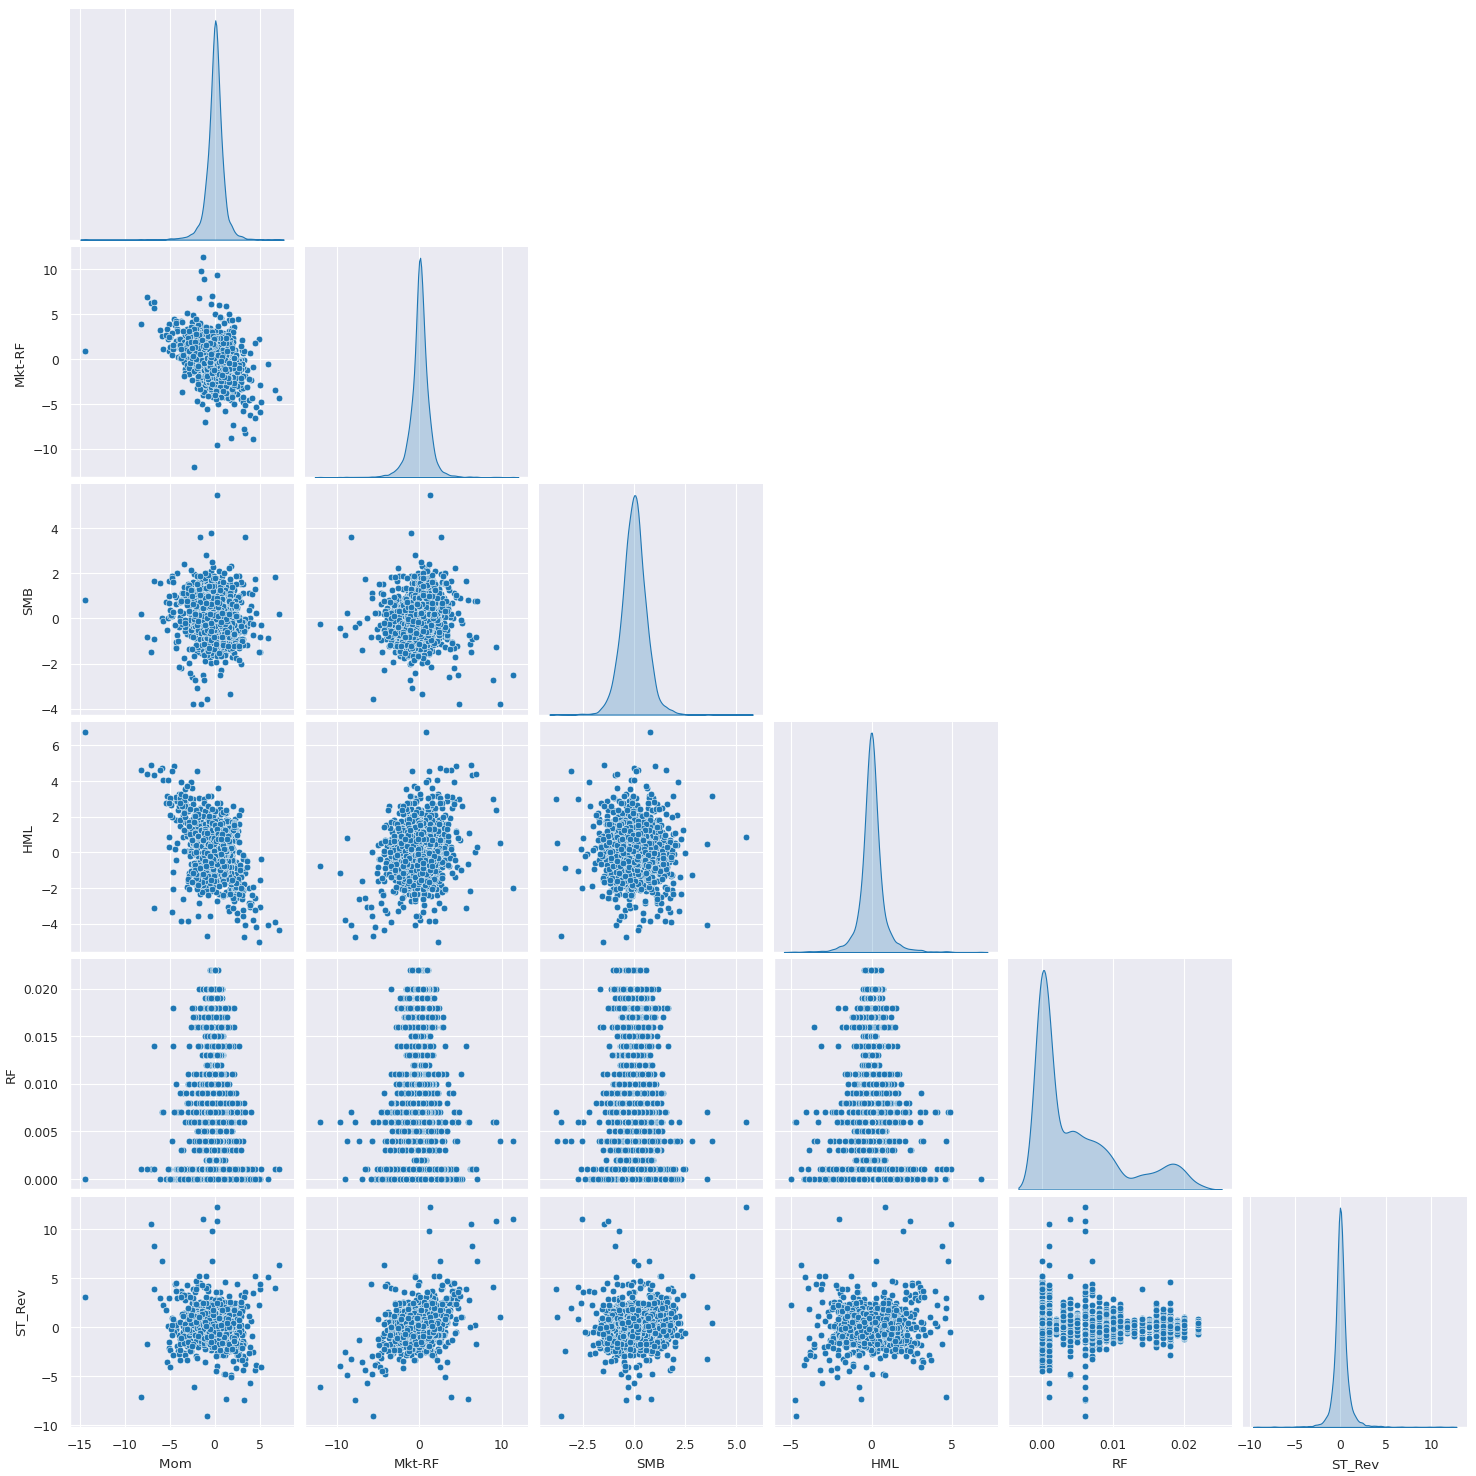

In [524]:
quick_distr_and_scatter_plot(fama_french)

The *RF* should be dropped, as it is not an actual factor

In [533]:
fama_french.drop(columns="RF", inplace=True)

In [536]:
fama_french = fama_french[start_date:end_date].copy()

In [537]:
fama_french

,Mom,Mkt-RF,SMB,HML,ST_Rev
Date,,,,,
2003-01-02,-1.60,3.14,-0.81,-0.35,2.29
2003-01-03,-0.02,-0.11,-0.47,0.16,-0.08
2003-01-06,-1.87,2.13,-0.55,-0.42,0.13
2003-01-07,-0.90,-0.63,0.22,-0.12,0.40
2003-01-08,1.02,-1.34,0.06,0.56,-0.08
...,...,...,...,...,...
2022-12-23,0.98,0.51,-0.60,1.15,0.43
2022-12-27,2.16,-0.51,-0.73,1.43,-1.38
2022-12-28,-0.32,-1.23,-0.24,-0.29,-0.01


# AQR

In [544]:
pd.Timestamp.today()

Timestamp('2023-04-28 14:16:39.159144')

In [554]:
def read_aqr(path:str, name:str, header=[17, 18], index_col=0, variable="Global", start_date="1900", end_date=None):
    try:
        df = pd.read_excel(path, header=header, index_col=index_col)
        # Set to datetime index
        df.index = pd.to_datetime(df.index)
        # Find global data
        df = df.xs("Global", level=1, axis=1).dropna()
        end_date = end_date if end_date is not None else pd.Timestamp.today()
        new_df = df.loc[start_date:end_date].copy()
        new_df.rename(columns={new_df.columns[0]:name}, inplace=True)
        del df
        return new_df
    except IOError:
        print(f"No such path exists: {path}")
    except KeyError:
        print(f"{variable} does not exist in the data")


## Load ticker names (links) and data

In [539]:
daily_tickers = {
    "BAB": "data/BAB.xlsx",
    "QMJ": "data/QMJ.xlsx",
    "HML_DEVIL": "data/Devil_HML.xlsx"
}
monthly_ticker = "https://www.aqr.com/-/media/AQR/Documents/Insights/Data-Sets/Time-Series-Momentum-Factors-Monthly.xlsx"

### Daily data
WARNING: Reading the data using the url takes a long time, so might be preferable to download

In [553]:
end_date

Timestamp('2022-12-30 00:00:00')

In [558]:
i = 0
for key, item in daily_tickers.items():
    if i == 0:
        aqr = read_aqr(item, name=key, start_date=start_date, end_date=end_date)
    else:
        other = read_aqr(item, name=key, start_date=start_date, end_date=end_date)
        aqr = aqr.join(other)
    i += 1

### NaNs

In [564]:
aqr.asfreq("B").info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5217 entries, 2003-01-02 to 2022-12-30
Freq: B
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   BAB        5217 non-null   float64
 1   QMJ        5217 non-null   float64
 2   HML_DEVIL  5217 non-null   float64
dtypes: float64(3)
memory usage: 163.0 KB


No NaNs are present even after setting to business days frequency, so no NaN handling is necessary

In [565]:
aqr = aqr.asfreq("B")

# QUANDL

## Load ticker names and data

In [567]:
quandl_tickers = data_names.loc[data_names["Data source"] == "QUANDL"].Ticker

In [568]:
quandl_tickers

44        USTREASURY/YIELD
45    USTREASURY/BILLRATES
46               LBMA/GOLD
Name: Ticker, dtype: object

In [599]:
yields = pdr.quandl.QuandlReader(symbols=quandl_tickers.iloc[0], api_key=nasdaq_api_key, start=start_date, end=end_date).read()
billrates = pdr.quandl.QuandlReader(symbols=quandl_tickers.iloc[1], api_key=nasdaq_api_key, start=start_date, end=end_date).read()
gold = pdr.quandl.QuandlReader(symbols=quandl_tickers.iloc[2], api_key=nasdaq_api_key, start=start_date, end=end_date).read()

All above datasets include multiple features. The ones of interest are:

In [600]:
data_names.loc[data_names["Data source"] == "QUANDL"].Name

44        Treasury yield curve rates (1-month maturity)
45      Treasury bill rates (4-week bank discount rate)
46    Gold fixing price (London a.m. and p.m. time) ...
Name: Name, dtype: object

In [602]:
gold.columns

Index(['USDAM', 'USDPM', 'GBPAM', 'GBPPM', 'EUROAM', 'EUROPM'], dtype='object')

In [606]:
yields_1mo = yields["1MO"].copy()
billrates_4wk = billrates["4WkBankDiscountRate"].copy()
gold_usdpm = gold["USDPM"].rename("Gold")
del yields, billrates, gold

In [607]:
quandl = yields_1mo.to_frame().join(billrates_4wk)
quandl = quandl.join(gold_usdpm).sort_index()
quandl

,1MO,4WkBankDiscountRate,Gold
Date,,,
2003-01-02,1.18,1.16,343.80
2003-01-03,1.18,1.16,344.50
2003-01-06,1.17,1.15,351.75
2003-01-07,1.17,1.15,349.00
2003-01-08,1.17,1.15,349.75
...,...,...,...
2022-12-23,3.80,3.65,NaN
2022-12-27,3.87,3.62,NaN
2022-12-28,3.86,3.57,1803.35


## NaNs

In [608]:
quandl.asfreq("B").info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5217 entries, 2003-01-02 to 2022-12-30
Freq: B
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   1MO                  5005 non-null   float64
 1   4WkBankDiscountRate  5004 non-null   float64
 2   Gold                 4870 non-null   float64
dtypes: float64(3)
memory usage: 163.0 KB


Quite a few NaNs, check consecutiveness

In [609]:
consecutive_nans(quandl.asfreq("B"))

1MO
Longest consecutive NaN gap: 1
--------------------
4WkBankDiscountRate
Longest consecutive NaN gap: 1
--------------------
Gold
Longest consecutive NaN gap: 3
Gap starts at at 2003-12-24 and ends at 2003-12-27
Number of gaps larger than 1: 
	Gap size: 2, number of gaps: 42
	Gap size: 3, number of gaps: 20
	
--------------------


Due to few consecutive NaNs, the data is forward filled

In [610]:
quandl = quandl.asfreq("B").fillna(method="ffill")
quandl

,1MO,4WkBankDiscountRate,Gold
Date,,,
2003-01-02,1.18,1.16,343.80
2003-01-03,1.18,1.16,344.50
2003-01-06,1.17,1.15,351.75
2003-01-07,1.17,1.15,349.00
2003-01-08,1.17,1.15,349.75
...,...,...,...
2022-12-26,3.80,3.65,1800.70
2022-12-27,3.87,3.62,1800.70
2022-12-28,3.86,3.57,1803.35


## Transformations

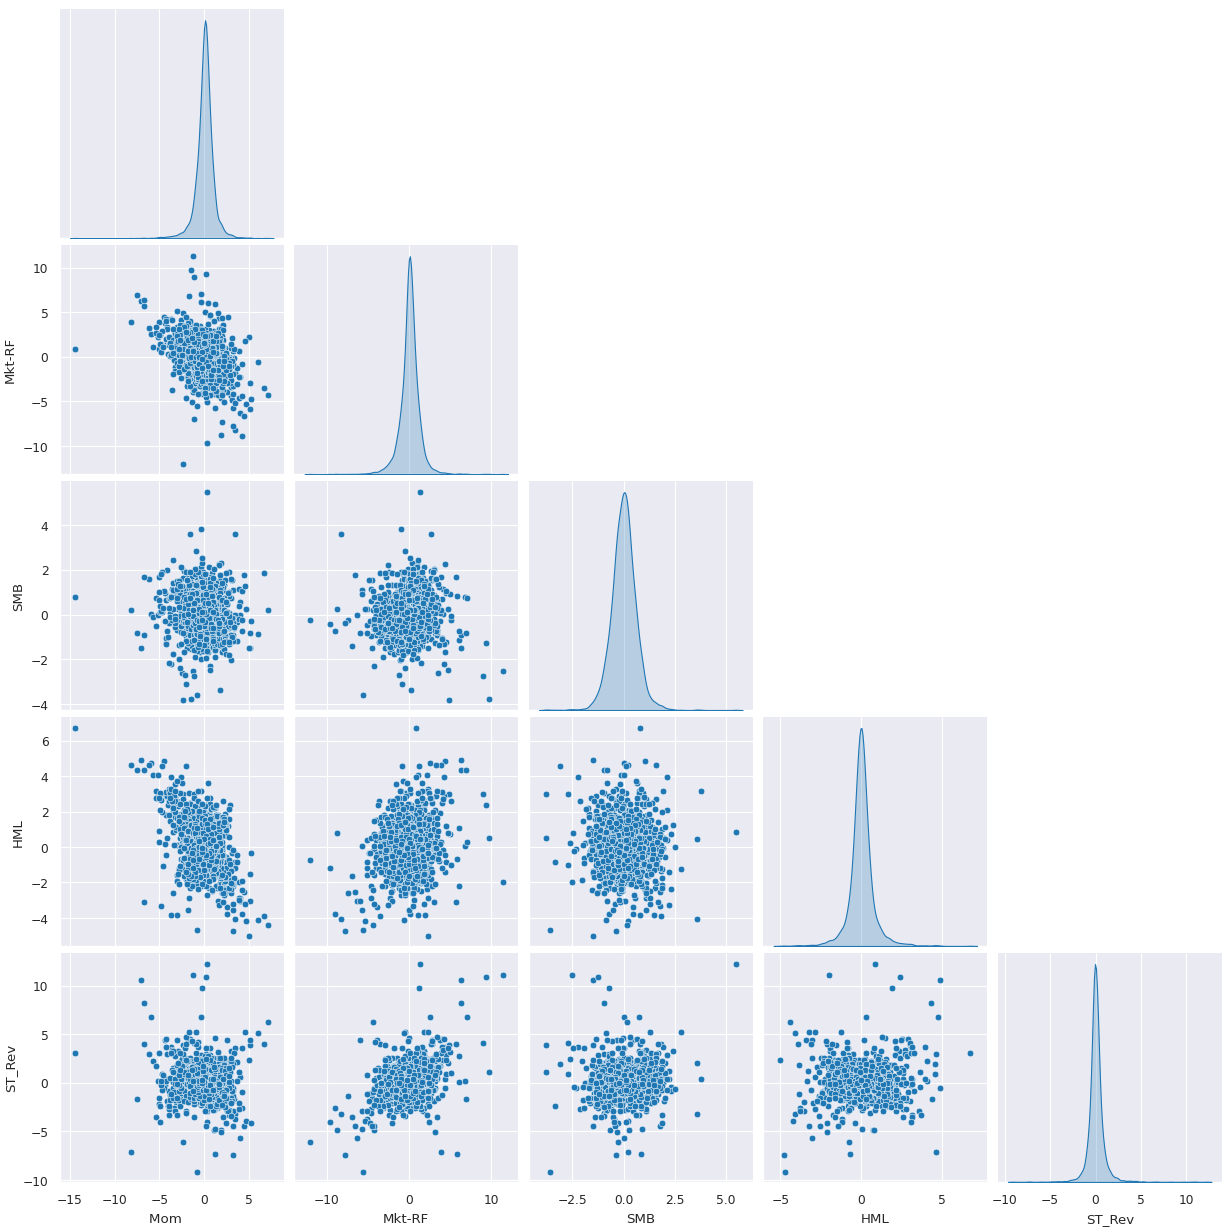

In [597]:
quick_distr_and_scatter_plot(quandl)

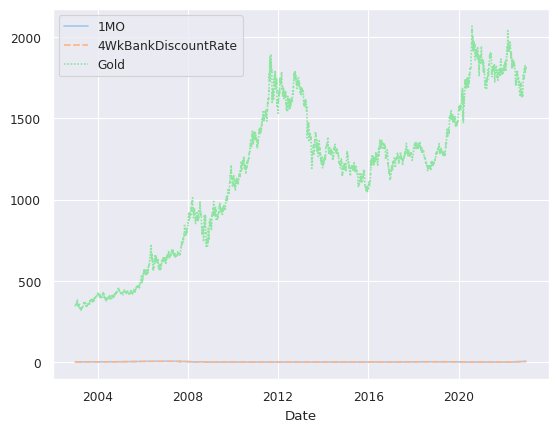

In [611]:
quick_lineplot(quandl)

As the gold price is not stationary, the returns are taken 

In [614]:
quandl["Gold_R"] = np.log1p(quandl.Gold / quandl.Gold.shift(1))

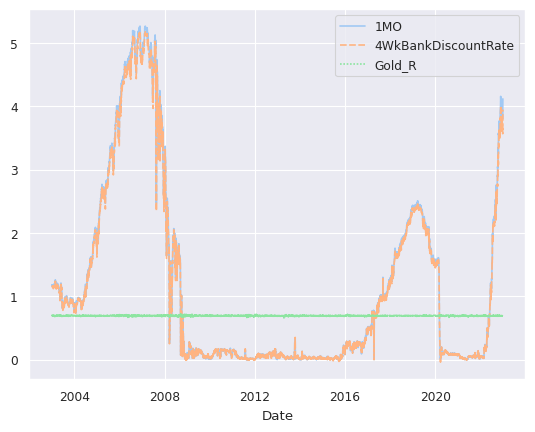

In [616]:
quick_lineplot(quandl, columns=["1MO", "4WkBankDiscountRate", "Gold_R"])

# AAII sentiments

## Load data and tickers

In [617]:
aaii = pd.read_excel("literature_data/sentiment.xlsx", header=3, index_col=0, nrows=1870, usecols=[0, 1, 2, 3, 5,6])
aaii.rename(columns={"Mov Avg":"Bullish 8-week Mov Avg", "Spread":"Bull-Bear Spread"}, inplace=True)

In [632]:
aaii = aaii.asfreq("B").loc[start_date:end_date]

Add bull-bear ratio as done in the source

In [637]:
aaii["Bull-Bear ratio"] = aaii.Bullish / aaii.Bearish

In [639]:
aaii

,Bullish,Neutral,Bearish,Bullish 8-week Mov Avg,Bull-Bear Spread,Bull-Bear ratio
Date,,,,,,
2003-01-02,0.324300,0.297300,0.37840,0.449850,-0.054100,0.857030
2003-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-07,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-08,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-12-26,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-27,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-28,NaN,NaN,NaN,NaN,NaN,NaN


## NaNs

As the data is weekly, should probably forward fill. Verify by checking consecutive NaNs

In [640]:
consecutive_nans(aaii)

Bullish
Longest consecutive NaN gap: 9
Gap starts at at 2021-01-08 and ends at 2021-01-17
Number of gaps larger than 1: 
	Gap size: 3, number of gaps: 8
	Gap size: 4, number of gaps: 1025
	Gap size: 5, number of gaps: 8
	Gap size: 9, number of gaps: 1
	
--------------------
Neutral
Longest consecutive NaN gap: 9
Gap starts at at 2021-01-08 and ends at 2021-01-17
Number of gaps larger than 1: 
	Gap size: 3, number of gaps: 8
	Gap size: 4, number of gaps: 1025
	Gap size: 5, number of gaps: 8
	Gap size: 9, number of gaps: 1
	
--------------------
Bearish
Longest consecutive NaN gap: 9
Gap starts at at 2021-01-08 and ends at 2021-01-17
Number of gaps larger than 1: 
	Gap size: 3, number of gaps: 8
	Gap size: 4, number of gaps: 1025
	Gap size: 5, number of gaps: 8
	Gap size: 9, number of gaps: 1
	
--------------------
Bullish 8-week Mov Avg
Longest consecutive NaN gap: 9
Gap starts at at 2021-01-08 and ends at 2021-01-17
Number of gaps larger than 1: 
	Gap size: 3, number of gaps: 8
	Gap si

Due to gaps of 9 (might be holidays or similar), forward filling is performed

In [641]:
aaii.fillna(method="ffill", inplace=True)

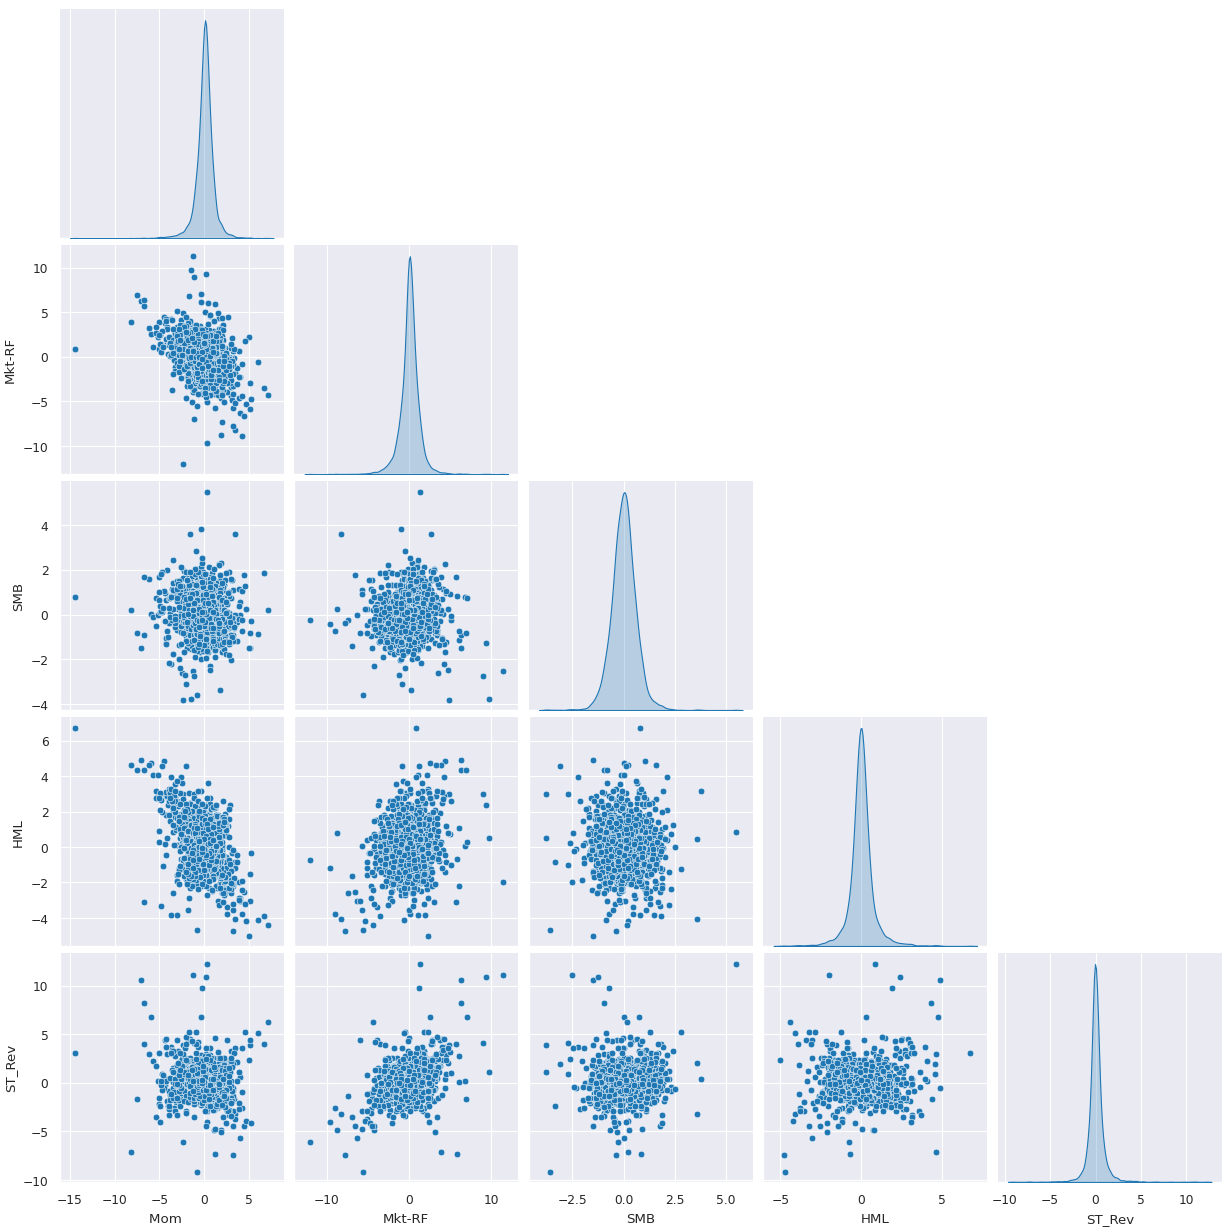

In [643]:
quick_distr_and_scatter_plot(aaii)

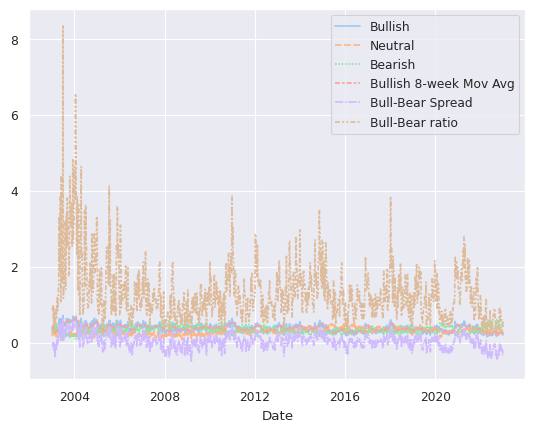

In [644]:
quick_lineplot(aaii)

# Merge data

Ensure the VIX adheres to the start and end date

In [648]:
vix = vix.loc[start_date:end_date]

## Ensure index and nulls are handled

In [660]:
vix = vix.asfreq("B")
vix.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5217 entries, 2003-01-02 to 2022-12-30
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VIX     5041 non-null   float64
dtypes: float64(1)
memory usage: 81.5 KB


Some NaNs in VIX

In [661]:
consecutive_nans(vix)

VIX
Longest consecutive NaN gap: 2
Gap starts at at 2007-01-01 and ends at 2007-01-03
Number of gaps larger than 1: 
	Gap size: 2, number of gaps: 2
	
--------------------


Short timespan, forward fill

In [662]:
vix.fillna(method="ffill", inplace=True)

In [659]:
daily_fred_updated = daily_fred_updated.asfreq("B")
daily_fred_updated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5217 entries, 2003-01-02 to 2022-12-30
Freq: B
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   T10Y3M          5217 non-null   float64
 1   BAA10Y          5217 non-null   float64
 2   DGS10           5217 non-null   float64
 3   DCOILWTICO      5217 non-null   float64
 4   DTWEXBGS        5217 non-null   float64
 5   USEPUINDXD      5217 non-null   float64
 6   WLEMUINDXD      5217 non-null   float64
 7   BAMLC0A4CBBB    5217 non-null   float64
 8   BAMLC0A1CAAA    5217 non-null   float64
 9   BAMLC0A4CBBBEY  5217 non-null   float64
 10  BAMLC0A1CAAAEY  5217 non-null   float64
 11  BAMLC0A0CM      5217 non-null   float64
 12  BAMLC0A0CMEY    5217 non-null   float64
 13  DFII5           5217 non-null   float64
 14  DFII10          5217 non-null   float64
 15  T5YIE           5217 non-null   float64
 16  T10YIE          5217 non-null   float64
 17  EFFR   

In [657]:
fama_french = fama_french.asfreq("B")
fama_french.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5217 entries, 2003-01-02 to 2022-12-30
Freq: B
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mom     5035 non-null   float64
 1   Mkt-RF  5035 non-null   float64
 2   SMB     5035 non-null   float64
 3   HML     5035 non-null   float64
 4   ST_Rev  5035 non-null   float64
dtypes: float64(5)
memory usage: 244.5 KB


In [663]:
quandl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5217 entries, 2003-01-02 to 2022-12-30
Freq: B
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   1MO                  5217 non-null   float64
 1   4WkBankDiscountRate  5217 non-null   float64
 2   Gold                 5217 non-null   float64
 3   Gold_R               5216 non-null   float64
dtypes: float64(4)
memory usage: 203.8 KB


In [664]:
aaii.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5217 entries, 2003-01-02 to 2022-12-30
Freq: B
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Bullish                 5217 non-null   float64
 1   Neutral                 5217 non-null   float64
 2   Bearish                 5217 non-null   float64
 3   Bullish 8-week Mov Avg  5217 non-null   float64
 4   Bull-Bear Spread        5217 non-null   float64
 5   Bull-Bear ratio         5217 non-null   float64
dtypes: float64(6)
memory usage: 285.3 KB


## Merge data

In [665]:
df = vix.join(daily_fred_updated)
df = df.join(fama_french)
df = df.join(quandl)
df = df.join(aaii)

## Check NaNs

In [667]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5217 entries, 2003-01-02 to 2022-12-30
Freq: B
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   VIX                     5217 non-null   float64
 1   T10Y3M                  5217 non-null   float64
 2   BAA10Y                  5217 non-null   float64
 3   DGS10                   5217 non-null   float64
 4   DCOILWTICO              5217 non-null   float64
 5   DTWEXBGS                5217 non-null   float64
 6   USEPUINDXD              5217 non-null   float64
 7   WLEMUINDXD              5217 non-null   float64
 8   BAMLC0A4CBBB            5217 non-null   float64
 9   BAMLC0A1CAAA            5217 non-null   float64
 10  BAMLC0A4CBBBEY          5217 non-null   float64
 11  BAMLC0A1CAAAEY          5217 non-null   float64
 12  BAMLC0A0CM              5217 non-null   float64
 13  BAMLC0A0CMEY            5217 non-null   float64
 14  DFII5         

In [672]:
consecutive_nans(df.loc[:, df.isna().any()])

DCOILWTICO_R
Longest consecutive NaN gap: 1
--------------------
DTWEXBGS_R
Longest consecutive NaN gap: 1
--------------------
Mom   
Longest consecutive NaN gap: 2
Gap starts at at 2007-01-01 and ends at 2007-01-03
Number of gaps larger than 1: 
	Gap size: 2, number of gaps: 2
	
--------------------
Mkt-RF
Longest consecutive NaN gap: 2
Gap starts at at 2007-01-01 and ends at 2007-01-03
Number of gaps larger than 1: 
	Gap size: 2, number of gaps: 2
	
--------------------
SMB
Longest consecutive NaN gap: 2
Gap starts at at 2007-01-01 and ends at 2007-01-03
Number of gaps larger than 1: 
	Gap size: 2, number of gaps: 2
	
--------------------
HML
Longest consecutive NaN gap: 2
Gap starts at at 2007-01-01 and ends at 2007-01-03
Number of gaps larger than 1: 
	Gap size: 2, number of gaps: 2
	
--------------------
ST_Rev
Longest consecutive NaN gap: 2
Gap starts at at 2007-01-01 and ends at 2007-01-03
Number of gaps larger than 1: 
	Gap size: 2, number of gaps: 2
	
--------------------
Gol

Some of the Fama-French factors has null values, but as these are only for a two-day gap these are forward filled

In [677]:
fama_french.columns

Index(['Mom   ', 'Mkt-RF', 'SMB', 'HML', 'ST_Rev'], dtype='object')

In [678]:
cols = ['Mom   ', "Mkt-RF", "SMB", "HML", "ST_Rev"]
df[cols] = df[cols].fillna(method="ffill")
df.rename(columns={'Mom   ':"Mom"}, inplace=True)

In [679]:
consecutive_nans(df.loc[:, df.isna().any()])

DCOILWTICO_R
Longest consecutive NaN gap: 1
--------------------
DTWEXBGS_R
Longest consecutive NaN gap: 1
--------------------
Gold_R
Longest consecutive NaN gap: 1
--------------------


*Gucci gang*

## Save as csv

In [687]:
df.to_csv("data/dataset.csv")

To read the file use:
```Python
pd.read_csv("data/dataset.csv", index_col=0, parse_dates=[0])
```

In [38]:
fred.search('Spread', order_by="popularity", limit=10).T

series id,T10Y2Y,BAMLH0A0HYM2,T10Y3M,T10YIE,T5YIE,T5YIFR,BAMLC0A4CBBB,BAMLC0A0CM,BAA10Y,BAMLH0A3HYC
id,T10Y2Y,BAMLH0A0HYM2,T10Y3M,T10YIE,T5YIE,T5YIFR,BAMLC0A4CBBB,BAMLC0A0CM,BAA10Y,BAMLH0A3HYC
realtime_start,2023-04-21 00:00:00,2023-04-21 00:00:00,2023-04-21 00:00:00,2023-04-21 00:00:00,2023-04-21 00:00:00,2023-04-21 00:00:00,2023-04-21 00:00:00,2023-04-21 00:00:00,2023-04-21 00:00:00,2023-04-21 00:00:00
realtime_end,2023-04-21 00:00:00,2023-04-21 00:00:00,2023-04-21 00:00:00,2023-04-21 00:00:00,2023-04-21 00:00:00,2023-04-21 00:00:00,2023-04-21 00:00:00,2023-04-21 00:00:00,2023-04-21 00:00:00,2023-04-21 00:00:00
title,10-Year Treasury Constant Maturity Minus 2-Yea...,ICE BofA US High Yield Index Option-Adjusted S...,10-Year Treasury Constant Maturity Minus 3-Mon...,10-Year Breakeven Inflation Rate,5-Year Breakeven Inflation Rate,"5-Year, 5-Year Forward Inflation Expectation Rate",ICE BofA BBB US Corporate Index Option-Adjuste...,ICE BofA US Corporate Index Option-Adjusted Sp...,Moody's Seasoned Baa Corporate Bond Yield Rela...,ICE BofA CCC & Lower US High Yield Index Optio...
observation_start,1976-06-01 00:00:00,1996-12-31 00:00:00,1982-01-04 00:00:00,2003-01-02 00:00:00,2003-01-02 00:00:00,2003-01-02 00:00:00,1996-12-31 00:00:00,1996-12-31 00:00:00,1986-01-02 00:00:00,1996-12-31 00:00:00
observation_end,2023-04-20 00:00:00,2023-04-19 00:00:00,2023-04-20 00:00:00,2023-04-20 00:00:00,2023-04-20 00:00:00,2023-04-20 00:00:00,2023-04-19 00:00:00,2023-04-19 00:00:00,2023-04-19 00:00:00,2023-04-19 00:00:00
frequency,Daily,"Daily, Close",Daily,Daily,Daily,Daily,"Daily, Close","Daily, Close",Daily,"Daily, Close"
frequency_short,D,D,D,D,D,D,D,D,D,D
units,Percent,Percent,Percent,Percent,Percent,Percent,Percent,Percent,Percent,Percent
units_short,%,%,%,%,%,%,%,%,%,%


In [ ]:
df = fred.search_by_category(101, limit=10, order_by='popularity', sort_order='desc')
df['title']


In [60]:
# Function for reading data from fama french using pandas datareader
def read_fama_french(dataset:str, start_date="1900") -> pd.DataFrame:
    result = pdr.famafrench.FamaFrenchReader(dataset, start=start).read()
    print(result["DESCR"])
    return result[0]

# Function for merging Fama-French data 
def merge_fama_french(left_df: pd.DataFrame, right_df:pd.DataFrame, on_feature="Date", how="outer") -> pd.DataFrame:
    result = pd.merge(left_df, right_df, how=how, on=on_feature)
    # Sort on index due to outer join and availability of data
    return result.sort_index()

In [50]:
pdr.famafrench.get_available_datasets()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_OP_Daily',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 'Portfolios_Formed_on_INV_Daily',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portf

In [57]:
a = pdr.famafrench.FamaFrenchReader("Portfolios_Formed_on_RESVAR").read()
temp = a[0]
print(a["DESCR"])
temp

Portfolios Formed on RESVAR
---------------------------

This file was created by CMPT_VAR_RETS using the 202302 CRSP database. It contains value- and equal-weighted returns for portfolios formed on VAR. The portfolios are constructed at the end of each month. The residual return variance is measured over 60 days up to formation monthend requiring at least 20 non-missing daily returns.  Annual returns are from January to December. Missing data are indicated by -99.99 or -999. The break points include utilities and include financials. The portfolios include utilities and include financials. Copyright 2023 Kenneth R. French

  0 : Value Weighted Returns -- Monthly (59 rows x 15 cols)
  1 : Equal Weighted Returns -- Monthly (59 rows x 15 cols)
  2 : Value Weighted Returns -- Annual from January to December (5 rows x 15 cols)
  3 : Equal Weighted Returns -- Annual from January to December (5 rows x 15 cols)
  4 : Number of Firms in Portfolios (59 rows x 15 cols)
  5 : Average Firm Size (59

,Lo 20,Qnt 2,Qnt 3,Qnt 4,Hi 20,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10
Date,,,,,,,,,,,,,,,
2018-04,0.25,0.91,0.08,0.66,0.59,0.00,0.62,0.35,1.54,-0.45,0.70,-0.65,2.68,1.04,-0.18
2018-05,1.26,3.68,2.91,4.02,7.66,0.54,2.47,4.44,2.76,3.14,2.63,5.59,1.02,8.14,6.97
2018-06,0.57,0.61,0.20,1.17,1.50,-0.14,1.35,0.85,0.46,-1.03,1.49,1.70,0.60,2.29,0.12
2018-07,5.37,2.87,1.26,2.08,-0.17,6.15,4.56,2.68,3.19,1.43,0.99,2.56,1.56,0.19,-0.65
2018-08,4.53,2.19,2.62,3.18,4.43,6.31,2.12,2.71,1.37,2.34,2.90,3.95,1.85,3.53,6.47
2018-09,0.55,0.26,0.51,-0.58,-3.49,0.12,0.95,-0.41,1.29,0.96,-0.06,-0.88,-0.17,-4.21,-2.05
2018-10,-6.26,-7.28,-7.82,-12.38,-11.63,-4.29,-8.59,-8.13,-6.39,-7.29,-8.63,-12.36,-12.40,-11.01,-13.02
2018-11,2.35,2.40,2.16,-3.30,0.23,3.93,-0.43,3.14,1.86,2.72,1.14,-4.88,-1.40,-1.43,2.21
2018-12,-8.92,-9.53,-8.81,-11.24,-12.28,-8.81,-9.23,-10.23,-8.58,-7.72,-10.41,-10.19,-12.61,-11.58,-12.93


In [43]:
#fama_french = 
temp = pdr.famafrench.FamaFrenchReader("F-F_Research_Data_Factors_daily", start="1900").read()
fama_french = temp[0]
temp["DESCR"]

'F-F Research Data Factors daily\n-------------------------------\n\nThis file was created by CMPT_ME_BEME_RETS_DAILY using the 202302 CRSP database. The Tbill return is the simple daily rate that, over the number of trading days in the month, compounds to 1-month TBill rate from Ibbotson and Associates Inc. Copyright 2023 Kenneth R. French\n\n  0 : (25438 rows x 4 cols)'

In [45]:
fama_french

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-01,0.10,-0.25,-0.27,0.009
1926-07-02,0.45,-0.33,-0.06,0.009
1926-07-06,0.17,0.30,-0.39,0.009
1926-07-07,0.09,-0.58,0.02,0.009
1926-07-08,0.21,-0.38,0.19,0.009
...,...,...,...,...
2023-02-22,-0.04,0.55,-0.43,0.018
2023-02-23,0.46,0.21,-0.23,0.018
2023-02-24,-1.09,-0.49,1.26,0.018


In [3]:
mom = pdr.famafrench.FamaFrenchReader("F-F_Momentum_Factor_daily", start="1900").read()
mom_df = mom[0]
mom["DESCR"]

'F-F Momentum Factor daily\n-------------------------\n\nThis file was created by CMPT_ME_PRIOR_RETS_DAILY using the 202302 CRSP database. It contains a momentum factor, constructed from six value-weight portfolios formed using independent sorts on size and prior return of NYSE, AMEX, and NASDAQ stocks. MOM is the average of the returns on two (big and small) high prior return portfolios minus the average of the returns on two low prior return portfolios. The portfolios are constructed daily. Big means a firm is above the median market cap on the NYSE at the end of the previous day; small firms are below the median NYSE market cap. Prior return is measured from day - 250 to - 21. Firms in the low prior return portfolio are below the 30th NYSE percentile. Those in the high portfolio are above the 70th NYSE percentile. Missing data are indicated by -99.99 or -999. Copyright 2023 Kenneth R. French\n\n  0 : (25337 rows x 1 cols)'

In [4]:
strff = pdr.famafrench.FamaFrenchReader("F-F_ST_Reversal_Factor_daily", start="1900").read()
str_df = strff[0]
strff["DESCR"]

'F-F ST Reversal Factor daily\n----------------------------\n\nThis file was created by CMPT_ME_PRIOR_RETS_DAILY using the 202302 CRSP database. It contains a momentum factor, constructed from six value-weight portfolios formed using independent sorts on size and prior return of NYSE, AMEX, and NASDAQ stocks. ST_REV is the average of the returns on two (big and small) low prior return portfolios minus the average of the returns on two high prior return portfolios. The portfolios are constructed daily. Big means a firm is above the median market cap on the NYSE at the end of the previous day; small firms are below the median NYSE market cap. Prior return is measured from day - 20 to - 1. Firms in the low prior return portfolio are below the 30th NYSE percentile. Those in the high portfolio are above the 70th NYSE percentile. Missing data are indicated by -99.99 or -999. Copyright 2023 Kenneth R. French\n\n  0 : (25567 rows x 1 cols)'

In [ ]:
rvar = pdr.famafrench.FamaFrenchReader("Portfolios_Formed_on_RESVAR", start="1900").read()
rvar[0]

,Lo 20,Qnt 2,Qnt 3,Qnt 4,Hi 20,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10
Date,,,,,,,,,,,,,,,
1963-07,0.47,-1.36,-0.60,-0.32,-1.37,0.33,0.95,-1.17,-1.64,-0.07,-1.45,0.93,-2.32,-1.25,-1.48
1963-08,4.66,6.55,5.60,6.54,7.80,4.26,6.21,6.26,6.91,5.77,5.29,6.48,6.63,10.25,5.26
1963-09,-0.76,-1.80,-2.09,-2.45,-2.37,-0.32,-2.24,-2.01,-1.52,-1.67,-2.51,-3.66,-0.38,-2.54,-2.18
1963-10,3.20,2.33,1.81,2.55,2.86,4.11,0.86,1.86,2.85,1.57,2.06,1.92,3.69,4.57,1.36
1963-11,-0.34,-1.18,-0.28,-0.89,-1.32,-0.08,-0.85,-0.74,-1.72,-0.85,0.39,-0.85,-0.93,-0.23,-2.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10,8.96,6.86,9.99,5.21,4.59,8.79,9.11,8.84,4.80,13.61,5.87,3.21,10.00,7.33,1.25
2022-11,5.28,6.67,4.01,2.37,3.04,6.14,4.62,6.64,6.72,1.91,8.03,1.70,3.86,5.52,-2.94
2022-12,-4.82,-5.43,-7.26,-11.67,-6.60,-3.84,-5.94,-5.14,-5.84,-7.54,-6.79,-13.80,-7.57,-6.03,-8.14


In [6]:
rvar = pdr.famafrench.FamaFrenchReader("25_Portfolios_ME_RESVAR_5x5", start="1900").read()
rvar[0]

,SMALL LoVAR,ME1 VAR2,ME1 VAR3,ME1 VAR4,SMALL HiVAR,ME2 VAR1,ME2 VAR2,ME2 VAR3,ME2 VAR4,ME2 VAR5,...,ME4 VAR1,ME4 VAR2,ME4 VAR3,ME4 VAR4,ME4 VAR5,BIG LoVAR,ME5 VAR2,ME5 VAR3,ME5 VAR4,BIG HiVAR
Date,,,,,,,,,,,,,,,,,,,,,
1963-07,-0.6035,0.6981,-0.4697,0.8372,-1.3083,0.0472,-0.6401,-2.7876,-0.7592,-2.3461,...,-0.7401,-1.7412,-1.1363,-1.3087,-1.9904,0.4593,0.1086,0.9318,-1.7820,0.6335
1963-08,2.7084,2.7094,4.2904,4.0278,1.9757,2.6689,5.0909,4.9102,6.9105,5.6686,...,4.0926,5.0501,5.4848,5.5302,8.0225,4.1754,6.6354,6.4857,6.6211,7.0982
1963-09,0.4875,-0.0417,0.1250,-2.3740,-1.3400,0.0522,-1.3389,-2.4922,-2.5715,-2.6436,...,-0.8287,-2.4694,-1.6136,-2.9487,-3.3051,-0.2819,-1.5448,-1.9760,-1.9671,-1.8725
1963-10,0.9552,2.0174,2.6815,0.2695,-0.7700,1.1492,1.9016,1.9084,3.3328,3.3823,...,-0.3948,0.8867,0.8896,1.5959,2.1141,4.6067,0.5689,1.9448,3.1988,2.8375
1963-11,-0.8483,-0.3783,-0.4834,-2.4505,-3.5411,-0.3628,-0.1355,-0.5553,-0.9127,-4.0689,...,0.1458,-0.6769,-1.3791,0.2639,0.0171,1.5753,-2.5897,-0.7402,-1.4440,-0.2586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10,6.1910,10.3835,10.7440,6.5769,1.4067,13.2377,13.3733,10.4015,10.0288,8.6969,...,11.1002,8.8203,10.1274,6.2947,5.1469,8.6700,8.9496,9.3749,7.6375,4.4291
2022-11,2.7272,2.2067,-0.8771,-3.0702,-6.9354,3.0644,1.9450,3.3049,0.0828,-2.8333,...,4.4594,6.7223,7.0939,5.1684,4.0100,6.3166,7.4353,3.9110,5.4591,3.1893
2022-12,-2.5396,-4.5540,-6.5580,-5.7018,-7.3760,-5.3161,-5.2058,-6.7185,-5.4417,-5.1085,...,-3.5336,-4.5927,-5.4597,-5.4272,-8.2958,-3.9402,-3.6153,-7.0904,-6.8921,-10.0291


## AQR Data

In [105]:
def read_aqr(path:str, header=[17, 18], index_col=0, variable="Global"):
    try:
        df = pd.read_excel(path, header=header, index_col=index_col)
        # Set to datetime index
        df.index = pd.to_datetime(df.index)
        # Find global data
        return df.xs("Global", level=1, axis=1).dropna()
    except IOError:
        print(f"No such path exists: {path}")
    except KeyError:
        print(f"{variable} does not exist in the data")

In [118]:
bab_df = read_aqr("literature_data/BAB_monthly.xlsx")
bab_df

,Aggregate Equity Portfolios
1987-02-28,0.006013
1987-03-31,0.047915
1987-04-30,0.001452
1987-05-31,-0.003499
1987-06-30,0.022201
...,...
2022-09-30,-0.007246
2022-10-31,0.001618
2022-11-30,-0.005760
2022-12-31,0.008223


In [119]:
qmj_df = read_aqr("literature_data/QMJ_monthly.xlsx")
qmj_df

,Aggregate Equity Portfolios
1989-07-31,0.012382
1989-08-31,0.000980
1989-09-30,0.002708
1989-10-31,0.031229
1989-11-30,0.007580
...,...
2022-09-30,0.035249
2022-10-31,0.023826
2022-11-30,0.024965
2022-12-31,0.019584


## FRED Data

## Data from AAII sentiment survey

In [143]:
aaii = pd.read_excel("literature_data/sentiment.xlsx", header=3, index_col=0, nrows=1870, usecols=[0, 1, 2, 3, 5,6])
aaii.rename(columns={"Mov Avg":"Bullish 8-week Mov Avg", "Spread":"Bull-Bear Spread"}, inplace=True)

In [147]:
aaii

,Bullish,Neutral,Bearish,Bullish 8-week Mov Avg,Bull-Bear Spread
Date,,,,,
NaT,NaN,NaN,NaN,NaN,NaN
1987-06-26,NaN,NaN,NaN,NaN,NaN
1987-07-17,NaN,NaN,NaN,NaN,NaN
1987-07-24,0.360000,0.500000,0.140000,NaN,0.220000
1987-07-31,0.260000,0.480000,0.260000,NaN,0.000000
...,...,...,...,...,...
2023-03-16,0.192171,0.323843,0.483986,0.258709,-0.291815
2023-03-23,0.209497,0.301676,0.488827,0.257262,-0.279330
2023-03-30,0.225100,0.318700,0.456100,0.256343,-0.231000


## Technical Indicators

On VIX:
* Moving average (5, 10 etc,)
* Momentum (5, 10 etc.)
    * The momentum can be defined as the 'slope' of the index, ie, the (percent) difference in today's value vs 5 days ago
* Bollinger Bands
* Exponential moving average
* Relative strength index
* ADX 
* Direction
* Average true range
    * $TR_\delta=max(H_\delta−L_\delta,|H_\delta - C_{/delta - 1}|,|L - C_{\delta - 1}|)$

## T

TODO data:
* All AQR datasets except BAB and QMJ

In [133]:
with pd.option_context("display.max_colwidth", 100):
    data = pd.read_csv("literature_data/Implied volatility directional forecasting a machine learning approach.csv")
    display(data)

,Code,Predictive Variable,Unit,Transformation,Source
0,1,VIX Index Level – End of period,(%),–,CBOE
1,2,SMB Factor Monthly Portfolio Returns – Small Minus Big – Size Factor,(%),–,Fama – French
2,3,HML Factor Monthly Portfolio Returns – High Minus Low -Value Factor,(%),–,Fama – French
3,4,MKT Factor Portfolio Returns – Equity Market Factor,(%),–,Fama – French
4,5,MOM Factor Portfolio Returns – Medium Price Momentum Factor,(%),–,Fama – French
5,6,STR Factor Portfolio Returns – Short Term Reversal Factor,(%),–,Fama – French
6,7,RVAR Factor Portfolio Returns – Residual Variance Factor,(%),–,Fama – French
7,8,BAB Factor Portfolio Returns – Betting Against Beta Factor,(%),–,AQR
8,9,QMJ Factor Portfolio Returns – Quality Minus Junk Factor,(%),–,AQR
9,10,Term spread – 10-year Treasury yield -3-month Tbill rate,(%),–,FRED Database


## EPU data monthly

In [171]:
epu = pd.read_excel("literature_data/Global_Policy_Uncertainty_Data.xlsx", nrows=313)
epu.index = pd.to_datetime(epu["Year"].astype(str) + "-"+ epu["Month"].astype(str))
epu.drop(columns=["Year", "Month"], inplace=True)
epu

,GEPU_current,GEPU_ppp
1997-01-01,76.907158,80.194378
1997-02-01,79.425501,82.377907
1997-03-01,68.601438,67.699160
1997-04-01,73.800689,76.152181
1997-05-01,71.874646,72.914702
...,...,...
2022-08-01,255.590262,260.310505
2022-09-01,275.353990,278.772533
2022-10-01,294.105381,297.370888
2022-11-01,330.213029,344.854386


## N